# Interactive Spotify Data Analysis

This notebook provides an interactive environment for analyzing Spotify track data. You can:

- Load data from CSV files or directly from the Spotify API
- Visualize audio features and track properties
- Perform clustering and find similar tracks
- Analyze correlations between audio features
- Compare tracks and playlists
- Generate track recommendations

Let's start by importing the necessary libraries and setting up our environment.

## 1. Import Required Libraries

Let's import all the libraries we'll need for our analysis:

In [32]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
# Set Plotly renderer to work better in this environment
pio.renderers.default = "colab"  # Using colab renderer which is more compatible

%pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, HTML

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Additional utilities
import time
import warnings
import json
warnings.filterwarnings('ignore')

# Set up plotting styles
plt.style.use('dark_background')
sns.set_style("darkgrid")

# Default plot size
plt.rcParams['figure.figsize'] = (12, 8)

# Custom color palette inspired by Spotify's branding
spotify_colors = ['#1DB954', '#1ED760', '#FFFFFF', '#191414', '#535353', '#B3B3B3']
spotify_palette = sns.color_palette(spotify_colors)
sns.set_palette(spotify_palette)

Note: you may need to restart the kernel to use updated packages.


## 2. Connect to Spotify API

Let's set up our connection to the Spotify API. You'll need to have a `.env` file with your Spotify API credentials or enter them directly.

### Security Note for GitHub Users:

For security reasons, never commit your `.env` file containing actual API credentials to GitHub. This notebook is designed to:

1. Look for credentials in a local `.env` file (which should be included in your `.gitignore`)
2. Fall back to manually entered credentials if needed (commented out in the code)

If you're cloning this repository:
- Copy `.env.example` to a new file called `.env`
- Fill in your own Spotify API credentials in the new `.env` file
- Make sure `.env` is in your `.gitignore` file (it should be already)

This way, your credentials stay private while the code remains functional for anyone who clones the repository.

In [33]:
# Load environment variables from .env file
load_dotenv()

# Get API credentials from environment variables
CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')

# If environment variables are not available, you can set them directly:
# CLIENT_ID = "your_client_id_here"
# CLIENT_SECRET = "your_client_secret_here"

# Function to initialize Spotify client
def initialize_spotify_client():
    try:
        client_credentials_manager = SpotifyClientCredentials(
            client_id=CLIENT_ID, 
            client_secret=CLIENT_SECRET
        )
        sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
        # Test the connection
        sp.new_releases(limit=1)
        print("✅ Successfully connected to Spotify API!")
        return sp
    except Exception as e:
        print(f"❌ Failed to connect to Spotify API: {str(e)}")
        print("Please check your API credentials and try again.")
        return None

# Initialize the Spotify client
sp = initialize_spotify_client()

✅ Successfully connected to Spotify API!


## 3. Load and Inspect Data

Let's create functions to load data either from local CSV files or from the Spotify API. We'll also define utility functions to inspect and preprocess the data.

In [34]:
# Function to load data from CSV files
def load_data_from_csv(file_path):
    """
    Load and process Spotify data from a CSV file
    """
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded data from {file_path}")
        print(f"   • {df.shape[0]} tracks with {df.shape[1]} features")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        return None

# Function to search for tracks using Spotify API
def search_tracks(query, limit=10):
    """
    Search for tracks on Spotify and return a DataFrame with track data
    """
    if sp is None:
        print("❌ Spotify client not initialized.")
        return None
    
    try:
        results = sp.search(q=query, type='track', limit=limit)
        tracks = results['tracks']['items']
        
        if not tracks:
            print("ℹ️ No tracks found for the query.")
            return None
            
        # Extract basic info from tracks
        track_data = []
        track_ids = []
        
        for track in tracks:
            track_ids.append(track['id'])
            
            track_info = {
                'track_id': track['id'],
                'track_name': track['name'],
                'track_popularity': track['popularity'],
                'track_href': track['href'],
                'uri': track['uri'],
                'track_artist': ', '.join([artist['name'] for artist in track['artists']]),
                'artist_id': track['artists'][0]['id'] if track['artists'] else None,
                'track_album_name': track['album']['name'],
                'track_album_id': track['album']['id'],
                'track_album_release_date': track['album']['release_date'],
                'duration_ms': track['duration_ms'],
                'album_image_url': track['album']['images'][0]['url'] if track['album']['images'] else None
            }
            
            track_data.append(track_info)
        
        # Create initial DataFrame
        tracks_df = pd.DataFrame(track_data)
        
        # Try to get audio features for these tracks
        try:
            audio_features = sp.audio_features(track_ids)
            
            # Add audio features to DataFrame
            for i, features in enumerate(audio_features):
                if features and i < len(tracks_df):
                    for feature in ['danceability', 'energy', 'key', 'loudness', 'mode', 
                                   'speechiness', 'acousticness', 'instrumentalness',
                                   'liveness', 'valence', 'tempo', 'time_signature']:
                        tracks_df.loc[i, feature] = features[feature]
        except Exception as e:
            print(f"⚠️ Warning: Could not retrieve audio features: {str(e)}")
        
        print(f"✅ Found {len(tracks_df)} tracks for query: '{query}'")
        return tracks_df
    
    except Exception as e:
        print(f"❌ Error searching tracks: {str(e)}")
        return None

# Function to get tracks from a Spotify playlist
def get_playlist_tracks(playlist_id):
    """
    Get all tracks from a Spotify playlist and return as a DataFrame
    """
    if sp is None:
        print("❌ Spotify client not initialized.")
        return None
    
    try:
        # Get playlist info
        try:
            playlist_info = sp.playlist(playlist_id)
            playlist_name = playlist_info['name']
            print(f"🎵 Retrieving tracks from playlist: {playlist_name}")
        except:
            playlist_name = "Unknown Playlist"
            print("⚠️ Warning: Could not retrieve playlist name")
        
        # Get all tracks (paginate through results)
        results = sp.playlist_tracks(playlist_id)
        tracks = results['items']
        
        while results['next']:
            results = sp.next(results)
            tracks.extend(results['items'])
        
        if not tracks:
            print("ℹ️ No tracks found in the playlist.")
            return None
        
        # Extract track info
        track_data = []
        track_ids = []
        
        for item in tracks:
            track = item.get('track')
            if not track:
                continue
                
            track_ids.append(track['id'])
            
            track_info = {
                'track_id': track['id'],
                'track_name': track['name'],
                'track_popularity': track.get('popularity', None),
                'track_href': track['href'],
                'uri': track['uri'],
                'track_artist': ', '.join([artist['name'] for artist in track['artists']]),
                'artist_id': track['artists'][0]['id'] if track['artists'] else None,
                'track_album_name': track['album']['name'],
                'track_album_id': track['album']['id'],
                'track_album_release_date': track['album']['release_date'],
                'duration_ms': track['duration_ms'],
                'album_image_url': track['album']['images'][0]['url'] if track['album']['images'] else None,
                'playlist_name': playlist_name,
                'playlist_id': playlist_id,
                'added_at': item['added_at']
            }
            
            track_data.append(track_info)
        
        # Create DataFrame
        tracks_df = pd.DataFrame(track_data)
        
        # Get audio features in batches
        try:
            # Process in batches of 100 (Spotify API limit)
            all_features = []
            for i in range(0, len(track_ids), 100):
                batch_ids = track_ids[i:i+100]
                features = sp.audio_features(batch_ids)
                all_features.extend(features)
                time.sleep(0.5)  # Avoid rate limiting
            
            # Add audio features to DataFrame
            for i, features in enumerate(all_features):
                if features and i < len(tracks_df):
                    for feature in ['danceability', 'energy', 'key', 'loudness', 'mode', 
                                   'speechiness', 'acousticness', 'instrumentalness',
                                   'liveness', 'valence', 'tempo', 'time_signature']:
                        if feature in features:
                            tracks_df.loc[i, feature] = features[feature]
        except Exception as e:
            print(f"⚠️ Warning: Could not retrieve audio features: {str(e)}")
        
        print(f"✅ Successfully retrieved {len(tracks_df)} tracks from playlist '{playlist_name}'")
        return tracks_df
    
    except Exception as e:
        print(f"❌ Error retrieving playlist tracks: {str(e)}")
        return None

In [35]:
# Let's load the sample CSV files
high_popularity_df = load_data_from_csv('high_popularity_spotify_data.csv')
low_popularity_df = load_data_from_csv('low_popularity_spotify_data.csv')

# Combine the datasets if both were loaded successfully
if high_popularity_df is not None and low_popularity_df is not None:
    # Add a label to identify the source
    high_popularity_df['popularity_category'] = 'high'
    low_popularity_df['popularity_category'] = 'low'
    
    # Combine the datasets
    df = pd.concat([high_popularity_df, low_popularity_df], ignore_index=True)
    print(f"✅ Combined dataset has {df.shape[0]} tracks with {df.shape[1]} features")
else:
    print("⚠️ Using only available datasets")
    df = high_popularity_df if high_popularity_df is not None else low_popularity_df

# Display basic information about the dataset
if df is not None:
    print("\n📊 Dataset Information:")
    display(df.info())
    
    print("\n📊 Summary Statistics:")
    display(df.describe())

✅ Successfully loaded data from high_popularity_spotify_data.csv
   • 1686 tracks with 29 features
✅ Successfully loaded data from low_popularity_spotify_data.csv
   • 3145 tracks with 29 features
✅ Combined dataset has 4831 tracks with 30 features

📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   energy                    4830 non-null   float64
 1   tempo                     4830 non-null   float64
 2   danceability              4830 non-null   float64
 3   playlist_genre            4831 non-null   object 
 4   loudness                  4830 non-null   float64
 5   liveness                  4830 non-null   float64
 6   valence                   4830 non-null   float64
 7   track_artist              4831 non-null   object 
 8   time_signature            4830 non-null   float64
 9   speechines

None


📊 Summary Statistics:


,energy,tempo,danceability,loudness,liveness,valence,time_signature,speechiness,track_popularity,instrumentalness,mode,key,duration_ms,acousticness
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4831.000000,4830.000000,4830.000000,4830.000000,4.830000e+03,4830.000000
mean,0.586691,118.269293,0.622311,-9.281627,0.167613,0.481930,3.936646,0.101738,54.761126,0.201053,0.562112,5.233333,2.061508e+05,0.341217
std,0.246263,28.512615,0.187706,7.129396,0.124429,0.258036,0.409712,0.101032,19.828573,0.351918,0.496178,3.580857,8.174556e+04,0.325382
min,0.000202,48.232000,0.058900,-48.069000,0.021000,0.029600,1.000000,0.021900,11.000000,0.000000,0.000000,0.000000,3.537500e+04,0.000004
25%,0.442250,96.063000,0.525000,-10.297750,0.095400,0.275000,4.000000,0.038600,41.000000,0.000000,0.000000,2.000000,1.590000e+05,0.052925
50%,0.633000,118.059500,0.653000,-7.191000,0.118000,0.483000,4.000000,0.056100,56.000000,0.000091,1.000000,5.000000,1.948665e+05,0.224500
75%,0.777000,136.723500,0.758000,-5.336750,0.195000,0.690000,4.000000,0.118000,72.000000,0.200500,1.000000,8.000000,2.334780e+05,0.590000
max,0.998000,241.426000,0.979000,1.318000,0.979000,0.987000,5.000000,0.927000,100.000000,0.991000,1.000000,11.000000,1.355260e+06,0.996000


## 4. Data Preprocessing

Let's clean and prepare our data for analysis. We'll handle missing values, standardize features, and create any necessary transformations.

In [36]:
def preprocess_data(df):
    """
    Clean and preprocess the Spotify data
    """
    if df is None or df.empty:
        print("❌ No data to preprocess")
        return None
    
    # Make a copy to avoid modifying the original
    processed_df = df.copy()
    
    print("🧹 Preprocessing data...")
    
    # 1. Handle missing values
    # For numeric audio features, fill with median values
    numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    for feature in numeric_features:
        if feature in processed_df.columns:
            if processed_df[feature].isna().sum() > 0:
                median_value = processed_df[feature].median()
                processed_df[feature].fillna(median_value, inplace=True)
                print(f"   • Filled missing values in '{feature}' with median: {median_value:.3f}")
    
    # For categorical features, fill with mode or a placeholder
    categorical_features = ['key', 'mode', 'time_signature']
    for feature in categorical_features:
        if feature in processed_df.columns:
            if processed_df[feature].isna().sum() > 0:
                mode_value = processed_df[feature].mode()[0]
                processed_df[feature].fillna(mode_value, inplace=True)
                print(f"   • Filled missing values in '{feature}' with mode: {mode_value}")
    
    # 2. Handle non-numeric audio features
    # Convert duration from ms to minutes
    if 'duration_ms' in processed_df.columns:
        processed_df['duration_min'] = processed_df['duration_ms'] / 60000
        print("   • Converted duration_ms to duration_min")
    
    # 3. Create derived features
    # Energy to valence ratio (emotional intensity)
    if all(f in processed_df.columns for f in ['energy', 'valence']):
        processed_df['intensity'] = processed_df['energy'] / (processed_df['valence'] + 0.01)
        print("   • Created 'intensity' feature (energy/valence ratio)")
    
    # Acoustic-electronic spectrum
    if 'acousticness' in processed_df.columns:
        processed_df['electronic'] = 1 - processed_df['acousticness']
        print("   • Created 'electronic' feature (1-acousticness)")
    
    # 4. Drop duplicate tracks
    if 'track_id' in processed_df.columns:
        before_drop = len(processed_df)
        processed_df.drop_duplicates(subset=['track_id'], inplace=True)
        after_drop = len(processed_df)
        if before_drop > after_drop:
            print(f"   • Removed {before_drop - after_drop} duplicate tracks")
    
    print(f"✅ Preprocessing complete! Final dataset has {processed_df.shape[0]} tracks with {processed_df.shape[1]} features")
    return processed_df

# Preprocess our dataset
processed_df = preprocess_data(df)

# Display the first few rows of the processed dataset
if processed_df is not None:
    display(processed_df.head())

🧹 Preprocessing data...
   • Filled missing values in 'danceability' with median: 0.653
   • Filled missing values in 'energy' with median: 0.633
   • Filled missing values in 'loudness' with median: -7.191
   • Filled missing values in 'speechiness' with median: 0.056
   • Filled missing values in 'acousticness' with median: 0.225
   • Filled missing values in 'instrumentalness' with median: 0.000
   • Filled missing values in 'liveness' with median: 0.118
   • Filled missing values in 'valence' with median: 0.483
   • Filled missing values in 'tempo' with median: 118.059
   • Filled missing values in 'key' with mode: 1.0
   • Filled missing values in 'mode' with mode: 1.0
   • Filled missing values in 'time_signature' with mode: 4.0
   • Converted duration_ms to duration_min
   • Created 'intensity' feature (energy/valence ratio)
   • Created 'electronic' feature (1-acousticness)
   • Removed 336 duplicate tracks
✅ Preprocessing complete! Final dataset has 4495 tracks with 33 feature

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id,popularity_category,duration_min,intensity,electronic
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high,4.194467,1.086239,0.6920
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high,3.506217,1.131696,0.8000
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high,2.771667,2.115183,0.7860
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high,2.621333,1.143216,0.9061
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high,2.831950,0.825079,0.9717


## 5. Feature Exploration and Visualization

Let's explore the audio features and create visualizations to understand our data better. We'll look at:

1. Distribution of individual features
2. Correlation between features
3. Scatter plots of key relationships
4. Clustering of tracks based on audio features

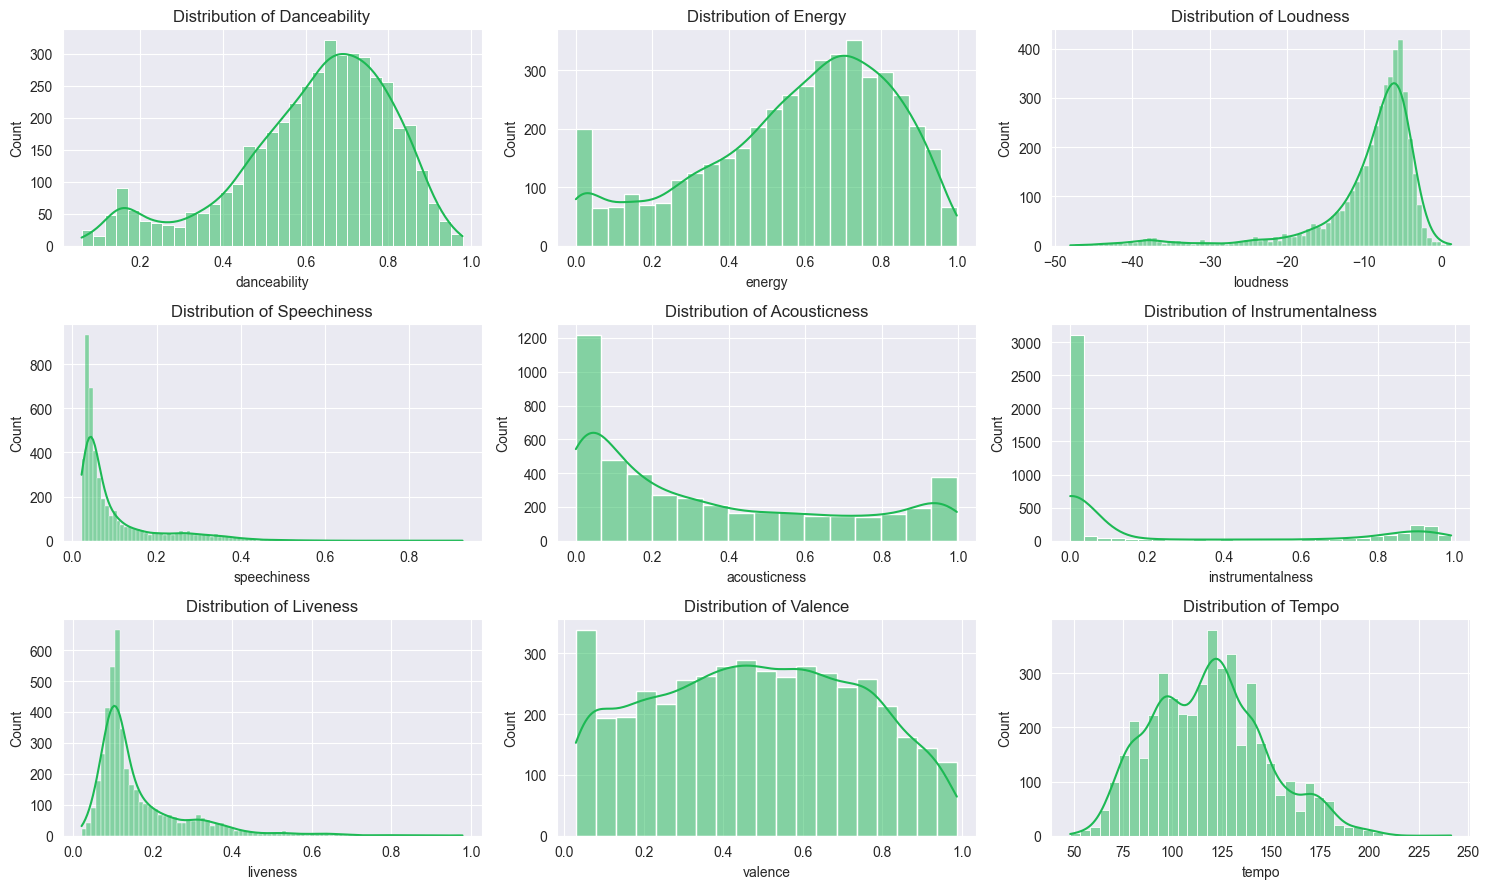

In [37]:
# Define the main audio features to explore
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Function to plot feature distributions
def plot_feature_distributions(df, features, n_cols=3):
    """
    Plot histograms for multiple features
    """
    # Filter to features that exist in the dataframe
    features = [f for f in features if f in df.columns]
    
    if not features:
        print("❌ No valid features to plot")
        return
    
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        if i < len(axes):
            sns.histplot(df[feature], kde=True, ax=axes[i], color='#1DB954')
            axes[i].set_title(f'Distribution of {feature.capitalize()}')
            axes[i].set_ylabel('Count')
    
    # Hide unused subplots
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot distributions of audio features
if processed_df is not None:
    plot_feature_distributions(processed_df, audio_features)

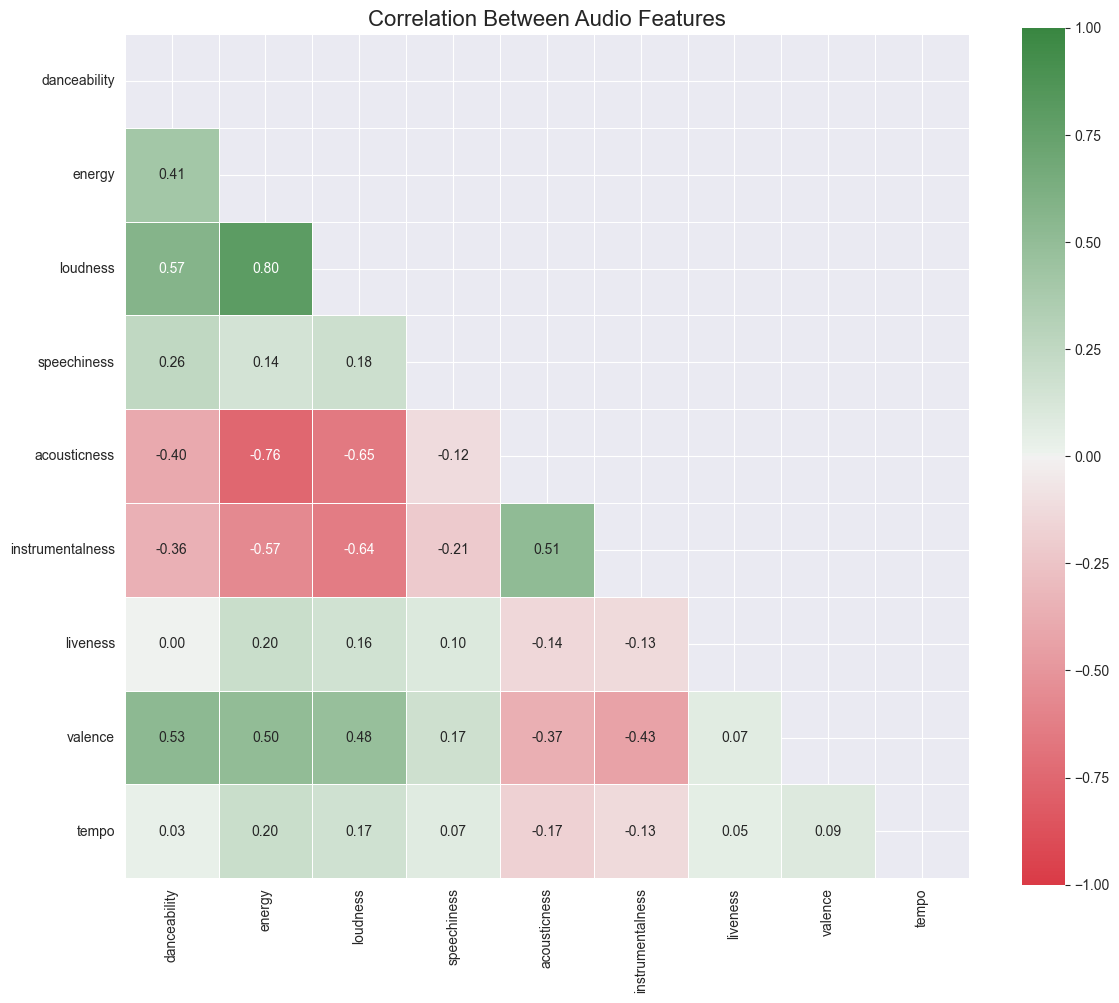

🔍 Strongest positive correlations:


loudness      energy          0.801668
energy        loudness        0.801668
danceability  loudness        0.571883
loudness      danceability    0.571883
valence       danceability    0.528794
dtype: float64


🔍 Strongest negative correlations:


energy        acousticness       -0.756526
acousticness  energy             -0.756526
              loudness           -0.650934
loudness      acousticness       -0.650934
              instrumentalness   -0.639827
dtype: float64

In [38]:
# Correlation analysis of audio features
if processed_df is not None:
    # Select only numeric features for correlation
    numeric_features = [f for f in audio_features if f in processed_df.columns]
    
    if len(numeric_features) >= 2:
        # Calculate the correlation matrix
        corr_matrix = processed_df[numeric_features].corr()
        
        # Plot the correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(10, 130, as_cmap=True)
        
        # Draw the heatmap
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                   square=True, linewidths=.5, annot=True, fmt='.2f')
        
        plt.title('Correlation Between Audio Features', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Highlight strongest correlations
        print("🔍 Strongest positive correlations:")
        pos_corr = corr_matrix.unstack().sort_values(ascending=False)
        # Remove self-correlations
        pos_corr = pos_corr[pos_corr < 1.0]
        display(pos_corr.head(5))
        
        print("\n🔍 Strongest negative correlations:")
        neg_corr = corr_matrix.unstack().sort_values()
        display(neg_corr.head(5))
    else:
        print("❌ Not enough numeric features for correlation analysis")

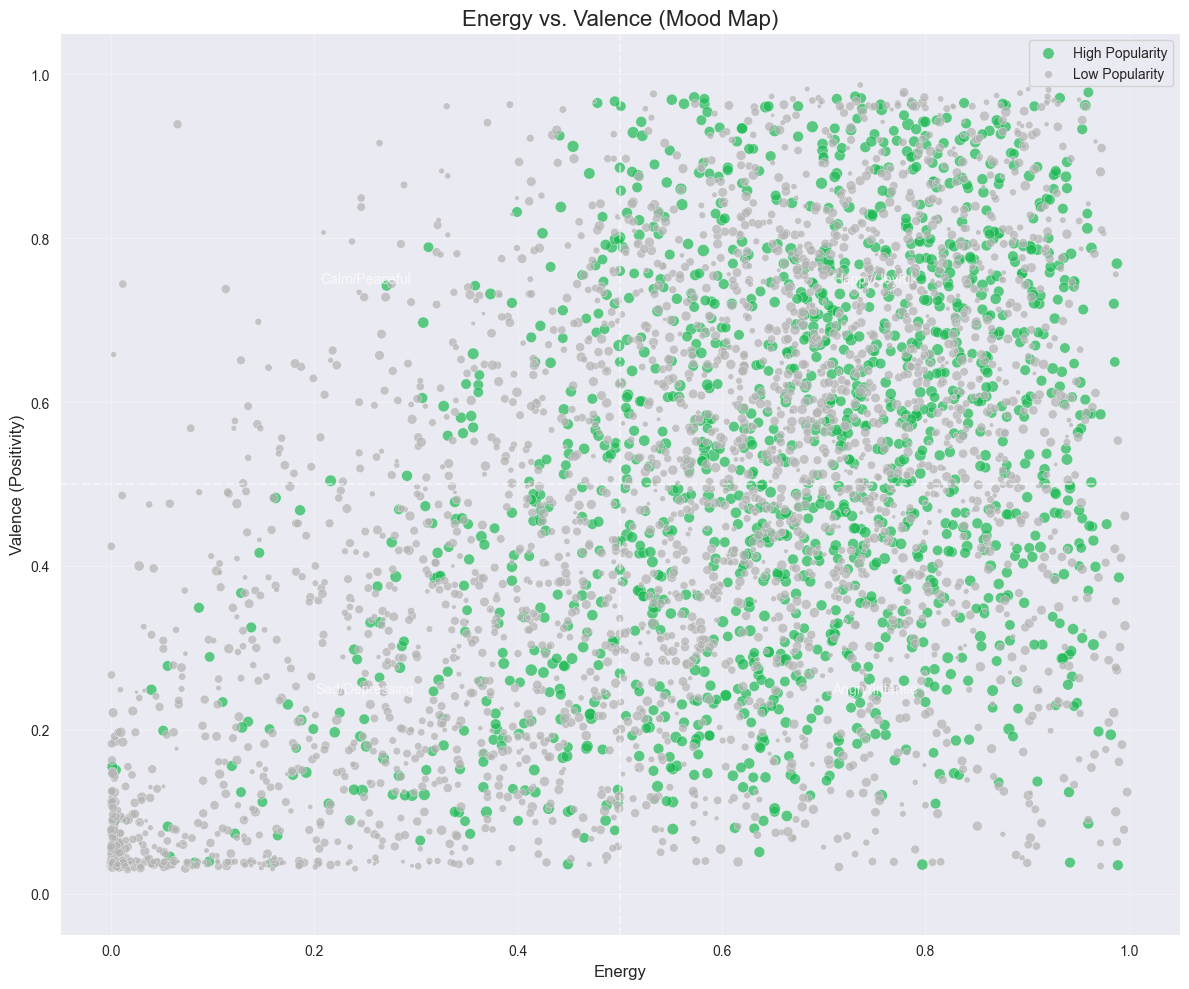

In [39]:
# Interactive scatter plot using matplotlib
import matplotlib.pyplot as plt

# Create a scatter plot using matplotlib instead of Plotly
if processed_df is not None:
    if all(f in processed_df.columns for f in ['energy', 'valence']):
        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Define colors based on popularity category if available
        if 'popularity_category' in processed_df.columns:
            # Create scatter plot with different colors for high vs low popularity
            for category, color, label in zip(['high', 'low'], ['#1DB954', '#B3B3B3'], ['High Popularity', 'Low Popularity']):
                subset = processed_df[processed_df['popularity_category'] == category]
                if 'track_popularity' in subset.columns:
                    # Use popularity for marker size
                    sizes = subset['track_popularity'] * 0.8
                    scatter = ax.scatter(subset['energy'], subset['valence'], 
                                  c=color, label=label, alpha=0.7,
                                  s=sizes, edgecolors='white', linewidth=0.3)
                else:
                    scatter = ax.scatter(subset['energy'], subset['valence'], 
                                  c=color, label=label, alpha=0.7,
                                  s=80, edgecolors='white', linewidth=0.3)
        else:
            # Create a single scatter plot
            if 'track_popularity' in processed_df.columns:
                sizes = processed_df['track_popularity'] * 0.8
                scatter = ax.scatter(processed_df['energy'], processed_df['valence'], 
                              c='#1DB954', alpha=0.7,
                              s=sizes, edgecolors='white', linewidth=0.3)
            else:
                scatter = ax.scatter(processed_df['energy'], processed_df['valence'], 
                              c='#1DB954', alpha=0.7,
                              s=80, edgecolors='white', linewidth=0.3)
        
        # Draw quadrant lines
        ax.axvline(x=0.5, color='white', linestyle='--', alpha=0.5)
        ax.axhline(y=0.5, color='white', linestyle='--', alpha=0.5)
        
        # Add quadrant annotations
        ax.text(0.25, 0.25, "Sad/Depressing", ha='center', va='center', color='white', alpha=0.7)
        ax.text(0.75, 0.25, "Angry/Intense", ha='center', va='center', color='white', alpha=0.7)
        ax.text(0.25, 0.75, "Calm/Peaceful", ha='center', va='center', color='white', alpha=0.7)
        ax.text(0.75, 0.75, "Happy/Joyful", ha='center', va='center', color='white', alpha=0.7)
        
        # Set title and labels
        ax.set_title('Energy vs. Valence (Mood Map)', fontsize=16)
        ax.set_xlabel('Energy', fontsize=12)
        ax.set_ylabel('Valence (Positivity)', fontsize=12)
        
        # Set axis limits
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        
        # Add legend if applicable
        if 'popularity_category' in processed_df.columns:
            ax.legend()
            
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Energy or valence features not available for scatter plot")

## 6. Clustering Analysis

Let's group tracks into clusters based on their audio features using K-means clustering. This can help identify similar songs and potentially discover patterns in music preferences.

🔍 Clustering tracks into 4 groups...
   • PCA explained variance: PC1=0.388, PC2=0.135
   • Total variance explained: 0.523


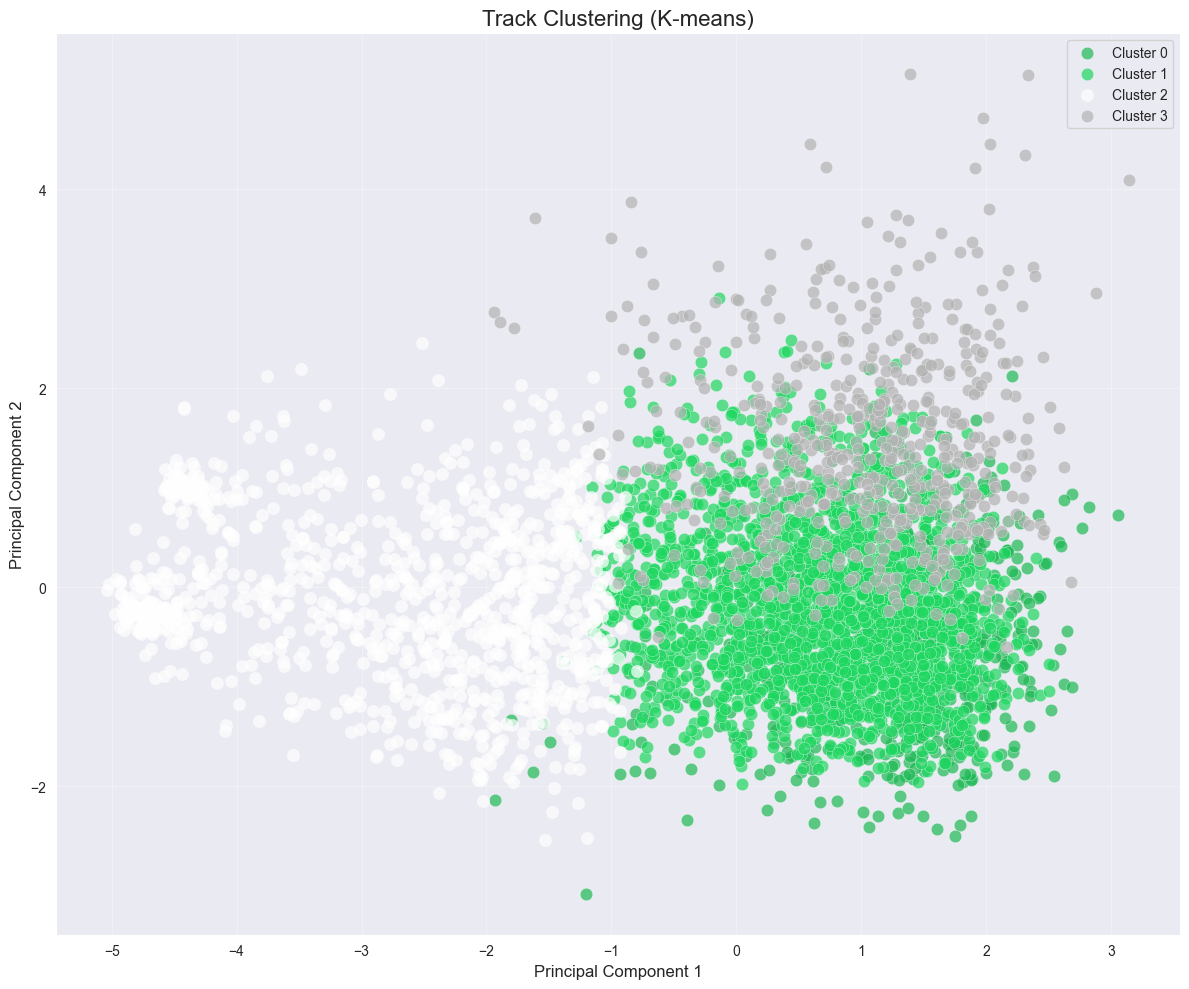


📊 Cluster Analysis:

Cluster 0 (639 tracks):
   • Higher tempo: 123.028 (+4.753)
   • Higher speechiness: 0.306 (+0.206)
   • Lower instrumentalness: 0.040 (-0.172)
   • Example tracks:
     - "Blow for Blow (feat. J. Cole)" by Tee Grizzley, J. Cole
     - "Hello Habibi" by Olamide
     - "Paces" by Lazlow

Cluster 1 (2230 tracks):
   • Higher tempo: 119.762 (+1.487)
   • Lower acousticness: 0.211 (-0.140)
   • Lower instrumentalness: 0.083 (-0.129)
   • Example tracks:
     - "FOMO" by Goldmax, Dlala Thukzin, Funky Qla, Zee Nxumalo, Beast Rsa
     - "Brighter" by Zusha
     - "Bon Voyage" by Dotter

Cluster 2 (1051 tracks):
   • Lower tempo: 109.059 (-9.216)
   • Higher instrumentalness: 0.661 (+0.449)
   • Higher acousticness: 0.792 (+0.441)
   • Example tracks:
     - "Stompin At The Savoy" by Benny Goodman
     - "Hijo de la Luna - Fils de la Lune" by The Top Club Band
     - "if it isn't" by METAHESH

Cluster 3 (575 tracks):
   • Higher tempo: 124.071 (+5.796)
   • Higher livenes

In [40]:
def cluster_tracks(df, n_clusters=4):
    """
    Cluster tracks based on audio features using K-means
    """
    if df is None or df.empty:
        print("❌ No data for clustering")
        return None
    
    print(f"🔍 Clustering tracks into {n_clusters} groups...")
    
    # Select features for clustering
    features_for_clustering = [
        'danceability', 'energy', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo'
    ]
    
    # Filter to features that exist in the dataframe
    features_for_clustering = [f for f in features_for_clustering if f in df.columns]
    
    if len(features_for_clustering) < 3:
        print("❌ Not enough audio features for clustering")
        return None
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features_for_clustering])
    
    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Add cluster labels to dataframe
    result_df = df.copy()
    result_df['cluster'] = cluster_labels
    
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)
    
    # Create a dataframe for plotting
    pca_df = pd.DataFrame(
        data=principal_components, 
        columns=['PC1', 'PC2']
    )
    pca_df['cluster'] = cluster_labels
    
    # Add track info if available
    if 'track_name' in df.columns:
        pca_df['track_name'] = df['track_name'].values
    
    if 'track_artist' in df.columns:
        pca_df['track_artist'] = df['track_artist'].values
    
    # Print the variance explained by the principal components
    explained_variance = pca.explained_variance_ratio_
    print(f"   • PCA explained variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}")
    print(f"   • Total variance explained: {sum(explained_variance):.3f}")
    
    # Create a scatter plot of the clusters using matplotlib
    plt.figure(figsize=(12, 10))
    
    # Define cluster colors
    cluster_colors = ['#1DB954', '#1ED760', '#FFFFFF', '#B3B3B3', '#535353', '#191414']
    
    # Ensure we have enough colors
    while len(cluster_colors) < n_clusters:
        cluster_colors.extend(cluster_colors)
    
    # Plot each cluster
    for cluster in range(n_clusters):
        cluster_data = pca_df[pca_df['cluster'] == cluster]
        plt.scatter(
            cluster_data['PC1'], 
            cluster_data['PC2'],
            c=cluster_colors[cluster],
            label=f'Cluster {cluster}',
            alpha=0.7,
            s=80,
            edgecolors='white',
            linewidth=0.3
        )
    
    plt.title("Track Clustering (K-means)", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Analyze clusters
    print("\n📊 Cluster Analysis:")
    for cluster in range(n_clusters):
        cluster_data = result_df[result_df['cluster'] == cluster]
        print(f"\nCluster {cluster} ({len(cluster_data)} tracks):")
        
        # Calculate mean values for each feature
        cluster_means = cluster_data[features_for_clustering].mean()
        
        # Compare to overall means
        overall_means = df[features_for_clustering].mean()
        diff = cluster_means - overall_means
        
        # Find top defining features (highest absolute difference)
        defining_features = diff.abs().sort_values(ascending=False).head(3)
        
        for feature in defining_features.index:
            value = cluster_means[feature]
            diff_value = diff[feature]
            if diff_value > 0:
                print(f"   • Higher {feature}: {value:.3f} (+{diff_value:.3f})")
            else:
                print(f"   • Lower {feature}: {value:.3f} ({diff_value:.3f})")
        
        # Show example tracks if available
        if 'track_name' in df.columns and 'track_artist' in df.columns:
            print("   • Example tracks:")
            examples = cluster_data.sample(min(3, len(cluster_data)))
            for _, track in examples.iterrows():
                print(f"     - \"{track['track_name']}\" by {track['track_artist']}")
    
    return result_df

# Run clustering on our processed data
if processed_df is not None:
    clustered_df = cluster_tracks(processed_df, n_clusters=4)

## 7. Track Comparison and Recommendations

Let's create tools to compare tracks and generate recommendations based on audio features. We'll use:

1. Radar charts to compare audio features between tracks
2. Similar track finding based on feature similarity
3. Playlist generation based on mood or feature preferences

📊 Top 5 Most Popular Tracks in Dataset:
1. "Die With A Smile" by Lady Gaga, Bruno Mars (popularity: 100)
2. "APT." by ROSÉ, Bruno Mars (popularity: 98)
3. "BIRDS OF A FEATHER" by Billie Eilish (popularity: 97)
4. "Good Luck, Babe!" by Chappell Roan (popularity: 94)
5. "Tu Boda" by Oscar Maydon, Fuerza Regida (popularity: 93)
🔍 Finding tracks similar to index 0...
📌 Target Track: "Die With A Smile" by Lady Gaga, Bruno Mars

🎵 Most Similar Tracks:
1. "Sweat" by Isak Danielson (index: 4368)
2. "For the First Time" by Mac DeMarco (index: 911)
3. "Would That I" by Hozier (index: 1304)
4. "Kayboldum" by Siyam (index: 2962)
5. "See You Again (feat. Kali Uchis)" by Tyler, The Creator, Kali Uchis (index: 625)


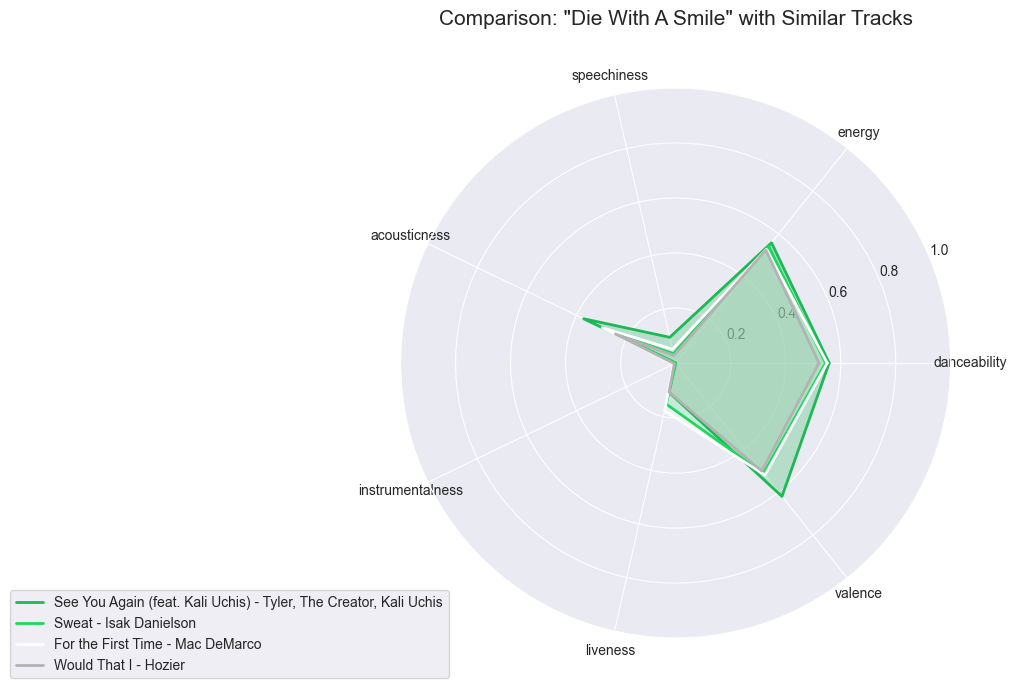

In [41]:
def compare_tracks(df, track_indices, title="Track Audio Feature Comparison"):
    """
    Create a radar chart comparing audio features of selected tracks using matplotlib
    """
    if df is None or df.empty:
        print("❌ No data for comparison")
        return
    
    if not track_indices or len(track_indices) < 1:
        print("❌ No tracks selected for comparison")
        return
    
    # Features to include in radar chart
    features = ['danceability', 'energy', 'speechiness', 'acousticness', 
               'instrumentalness', 'liveness', 'valence']
    
    # Filter to features that exist in the dataframe
    features = [f for f in features if f in df.columns]
    
    if not features:
        print("❌ No audio features available for comparison")
        return
    
    # Filter to selected tracks
    selected_df = df.iloc[track_indices]
    
    if selected_df.empty:
        print("❌ No valid tracks selected")
        return
    
    # Number of variables/features
    N = len(features)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    
    # Set the angle for each feature (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Set the labels for each spoke/feature
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    
    # Define colors
    colors = ['#1DB954', '#1ED760', '#FFFFFF', '#B3B3B3', '#535353', '#191414']
    
    # Plot each track
    for i, (idx, track) in enumerate(selected_df.iterrows()):
        # Get values for this track
        values = [track[feature] for feature in features]
        values += values[:1]  # Close the loop
        
        # Plot the values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{track.get('track_name', f'Track {idx}')} - {track.get('track_artist', 'Unknown')}", color=colors[i % len(colors)])
        ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.25)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add title
    plt.title(title, size=15, y=1.1)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

def find_similar_tracks(df, track_index, n=5):
    """
    Find tracks similar to the selected track based on audio features
    """
    if df is None or df.empty:
        print("❌ No data for finding similar tracks")
        return
    
    if track_index < 0 or track_index >= len(df):
        print(f"❌ Invalid track index: {track_index}")
        return
    
    print(f"🔍 Finding tracks similar to index {track_index}...")
    
    # Features to use for similarity
    features = ['danceability', 'energy', 'speechiness', 'acousticness', 
               'instrumentalness', 'liveness', 'valence']
    
    # Filter to features that exist in the dataframe
    features = [f for f in features if f in df.columns]
    
    if len(features) < 3:
        print("❌ Not enough audio features for similarity calculation")
        return
    
    # Normalize features for distance calculation
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[features])
    
    # Get the target track's features
    target_features = scaled_features[track_index]
    
    # Calculate Euclidean distance to all other tracks
    distances = []
    for i, track_features in enumerate(scaled_features):
        if i != track_index:  # Skip the target track itself
            dist = np.linalg.norm(target_features - track_features)
            distances.append((i, dist))
    
    # Sort by distance and get the top n
    similar_indices = [idx for idx, _ in sorted(distances, key=lambda x: x[1])[:n]]
    
    # Display the target track
    target_track = df.iloc[track_index]
    target_name = target_track.get('track_name', f"Track {track_index}")
    target_artist = target_track.get('track_artist', "Unknown Artist")
    
    print(f"📌 Target Track: \"{target_name}\" by {target_artist}")
    
    # Display similar tracks
    print(f"\n🎵 Most Similar Tracks:")
    similar_tracks = df.iloc[similar_indices]
    
    for i, (_, track) in enumerate(similar_tracks.iterrows()):
        track_name = track.get('track_name', f"Track {i}")
        track_artist = track.get('track_artist', "Unknown Artist")
        track_index = similar_indices[i]
        
        print(f"{i+1}. \"{track_name}\" by {track_artist} (index: {track_index})")
    
    # Compare the target track with similar tracks using a radar chart
    compare_indices = [track_index] + similar_indices[:3]  # Target + top 3 similar
    compare_tracks(df, compare_indices, title=f"Comparison: \"{target_name}\" with Similar Tracks")
    
    return similar_indices

# Let's find a track with good data to compare
if processed_df is not None and 'track_name' in processed_df.columns:
    # Find a popular track as an example
    if 'track_popularity' in processed_df.columns:
        popular_tracks = processed_df.sort_values('track_popularity', ascending=False).head(5)
        print("📊 Top 5 Most Popular Tracks in Dataset:")
        for i, (idx, track) in enumerate(popular_tracks.iterrows()):
            print(f"{i+1}. \"{track['track_name']}\" by {track['track_artist']} (popularity: {track['track_popularity']})")
        
        # Use the most popular track as an example
        example_index = popular_tracks.index[0]
        similar_indices = find_similar_tracks(processed_df, example_index, n=5)
    else:
        # Just pick the first track
        example_index = 0
        print(f"Using first track as example: \"{processed_df.iloc[0]['track_name']}\" by {processed_df.iloc[0]['track_artist']}")
        similar_indices = find_similar_tracks(processed_df, example_index, n=5)

🎵 Generating mood-based playlists...

🎧 Happy/Joyful Playlist (5 tracks):
1. "Die With A Smile" by Lady Gaga, Bruno Mars (popularity: 100)
2. "APT." by ROSÉ, Bruno Mars (popularity: 98)
3. "Good Luck, Babe!" by Chappell Roan (popularity: 94)
4. "Taste" by Sabrina Carpenter (popularity: 93)
5. "Si Antes Te Hubiera Conocido" by KAROL G (popularity: 93)

🎧 Calm/Peaceful Playlist (5 tracks):
1. "End of Beginning" by Djo (popularity: 89)
2. "Stick Season" by Noah Kahan (popularity: 87)
3. "Gata Only" by FloyyMenor, Cris Mj (popularity: 87)
4. "Rey Sin Reina" by Julión Álvarez y su Norteño Banda (popularity: 85)
5. "Evergreen" by Richy Mitch & The Coal Miners (popularity: 84)

🎧 Angry/Intense Playlist (5 tracks):
1. "BIRDS OF A FEATHER" by Billie Eilish (popularity: 97)
2. "That’s So True" by Gracie Abrams (popularity: 93)
3. "Tu Boda" by Oscar Maydon, Fuerza Regida (popularity: 93)
4. "Sweater Weather" by The Neighbourhood (popularity: 90)
5. "Yellow" by Coldplay (popularity: 89)

🎧 Sad/Dep

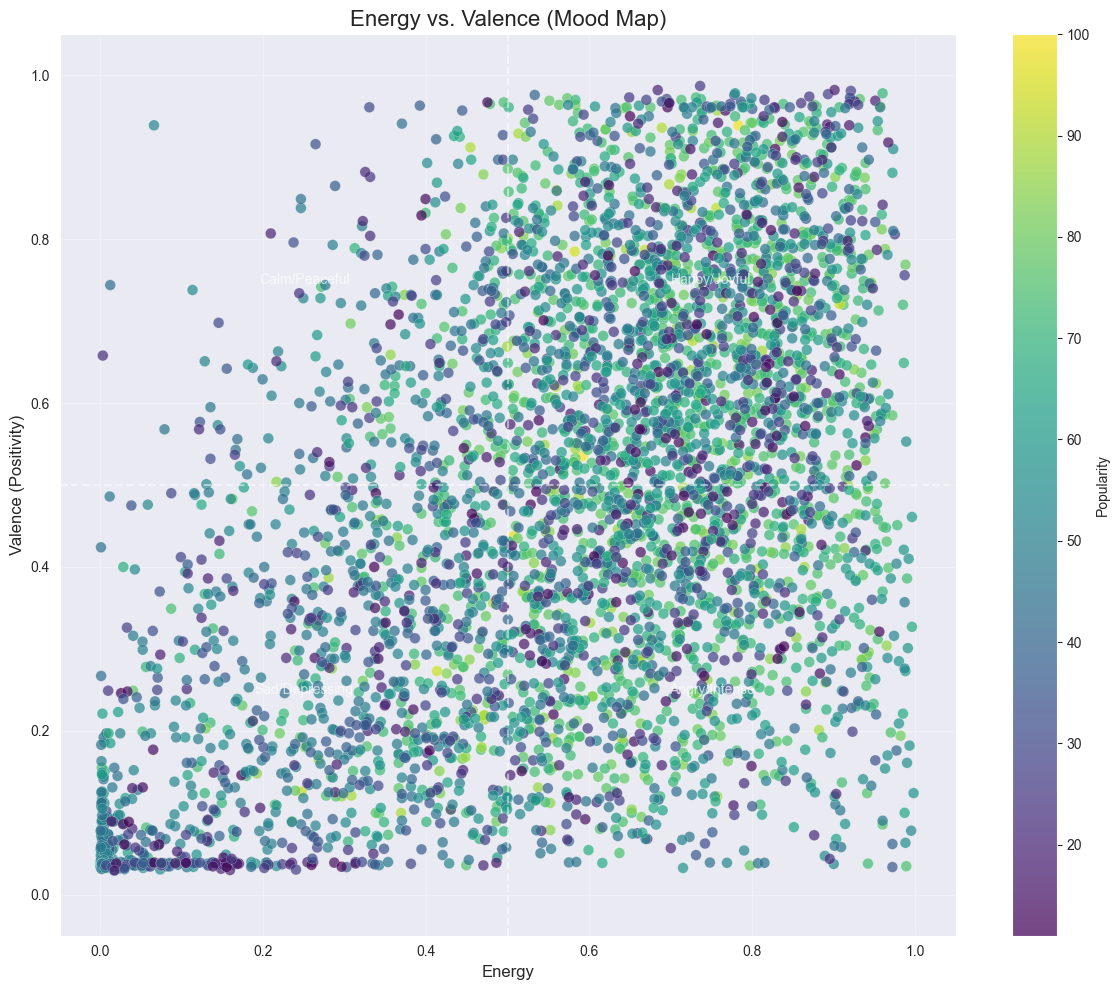

In [42]:
# Function to generate mood-based playlists
def generate_mood_playlists(df, n_tracks_per_mood=10):
    """
    Generate playlists based on mood quadrants using energy and valence
    """
    if df is None or df.empty:
        print("❌ No data for playlist generation")
        return
    
    # Check if we have the necessary features
    if 'energy' not in df.columns or 'valence' not in df.columns:
        print("❌ Energy or valence features not available for mood-based playlists")
        return
    
    print("🎵 Generating mood-based playlists...")
    
    # Define the mood quadrants
    moods = {
        'Happy/Joyful': (df['energy'] > 0.5) & (df['valence'] > 0.5),
        'Calm/Peaceful': (df['energy'] <= 0.5) & (df['valence'] > 0.5),
        'Angry/Intense': (df['energy'] > 0.5) & (df['valence'] <= 0.5),
        'Sad/Depressing': (df['energy'] <= 0.5) & (df['valence'] <= 0.5)
    }
    
    # Generate playlists for each mood
    for mood, condition in moods.items():
        mood_tracks = df[condition]
        
        if len(mood_tracks) == 0:
            print(f"\n❌ No tracks found for mood: {mood}")
            continue
        
        # Sort by popularity if available
        if 'track_popularity' in mood_tracks.columns:
            mood_tracks = mood_tracks.sort_values('track_popularity', ascending=False)
        
        # Take the top N tracks
        playlist = mood_tracks.head(n_tracks_per_mood)
        
        print(f"\n🎧 {mood} Playlist ({len(playlist)} tracks):")
        
        # Display the playlist
        if 'track_name' in playlist.columns and 'track_artist' in playlist.columns:
            for i, (_, track) in enumerate(playlist.iterrows()):
                popularity = f" (popularity: {track['track_popularity']})" if 'track_popularity' in track else ""
                print(f"{i+1}. \"{track['track_name']}\" by {track['track_artist']}{popularity}")
        else:
            print("  Track information not available")
    
    # Create a scatter plot showing the mood quadrants using matplotlib
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create colormap for popularity if available
    if 'track_popularity' in df.columns:
        scatter = ax.scatter(
            df['energy'], 
            df['valence'], 
            c=df['track_popularity'], 
            cmap='viridis', 
            alpha=0.7, 
            s=60,
            edgecolors='white',
            linewidth=0.2
        )
        
        # Add a colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Popularity')
    else:
        scatter = ax.scatter(
            df['energy'], 
            df['valence'], 
            c='#1DB954', 
            alpha=0.7, 
            s=60,
            edgecolors='white',
            linewidth=0.2
        )
    
    # Draw quadrant lines
    ax.axvline(x=0.5, color='white', linestyle='--', alpha=0.5)
    ax.axhline(y=0.5, color='white', linestyle='--', alpha=0.5)
    
    # Add quadrant annotations
    ax.text(0.25, 0.25, "Sad/Depressing", ha='center', va='center', color='white', alpha=0.7)
    ax.text(0.75, 0.25, "Angry/Intense", ha='center', va='center', color='white', alpha=0.7)
    ax.text(0.25, 0.75, "Calm/Peaceful", ha='center', va='center', color='white', alpha=0.7)
    ax.text(0.75, 0.75, "Happy/Joyful", ha='center', va='center', color='white', alpha=0.7)
    
    # Set title and labels
    ax.set_title('Energy vs. Valence (Mood Map)', fontsize=16)
    ax.set_xlabel('Energy', fontsize=12)
    ax.set_ylabel('Valence (Positivity)', fontsize=12)
    
    # Set axis limits
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Generate mood-based playlists
if processed_df is not None:
    generate_mood_playlists(processed_df, n_tracks_per_mood=5)

## 8. Live Spotify API Search and Recommendations

Let's create interactive widgets to search for tracks on Spotify and get recommendations based on selected tracks.

In [43]:
# Interactive search widget for Spotify
def create_search_widget():
    """
    Create interactive widgets for searching Spotify tracks
    """
    if sp is None:
        print("❌ Spotify API not connected. Cannot create search widget.")
        return
    
    # Create search widgets
    search_input = widgets.Text(
        value='',
        placeholder='Enter artist, track, or album',
        description='Search:',
        disabled=False
    )
    
    limit_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=30,
        step=1,
        description='Results:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    
    search_button = widgets.Button(
        description='Search Spotify',
        button_style='success', 
        icon='search'
    )
    
    output = widgets.Output()
    
    # Define search function
    def on_search_button_clicked(b):
        with output:
            output.clear_output()
            query = search_input.value.strip()
            
            if not query:
                print("❌ Please enter a search query")
                return
            
            print(f"🔍 Searching for: {query}")
            search_results = search_tracks(query, limit=limit_slider.value)
            
            if search_results is None or search_results.empty:
                print("❌ No results found")
                return
            
            global live_search_results  # Store for further analysis
            live_search_results = search_results
            
            # Display results in a table
            display(search_results[['track_name', 'track_artist', 'track_album_name', 'track_popularity']])
            
            # Create dropdown to select tracks for audio feature visualization
            track_options = [(f"{i}: {row['track_name']} - {row['track_artist']}", i) 
                            for i, (_, row) in enumerate(search_results.iterrows())]
            
            track_dropdown = widgets.Dropdown(
                options=track_options,
                description='Analyze:',
                disabled=False,
            )
            
            analyze_button = widgets.Button(
                description='Show Features',
                button_style='info',
                icon='chart-bar'
            )
            
            analyze_output = widgets.Output()
            
            def on_analyze_button_clicked(b):
                with analyze_output:
                    analyze_output.clear_output()
                    selected_index = track_dropdown.value
                    
                    if selected_index is None:
                        print("❌ Please select a track to analyze")
                        return
                    
                    # Plot audio features for the selected track
                    selected_track = search_results.iloc[selected_index]
                    
                    # Create a radar chart for the track
                    features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                               'instrumentalness', 'liveness', 'valence']
                    
                    # Filter to features that exist
                    features = [f for f in features if f in selected_track.index]
                    
                    if not features:
                        print("❌ No audio features available for this track")
                        return
                    
                    fig = go.Figure()
                    
                    values = [selected_track[feature] for feature in features]
                    
                    fig.add_trace(go.Scatterpolar(
                        r=values,
                        theta=features,
                        fill='toself',
                        name=f"{selected_track['track_name']} - {selected_track['track_artist']}"
                    ))
                    
                    fig.update_layout(
                        polar=dict(
                            radialaxis=dict(
                                visible=True,
                                range=[0, 1]
                            )
                        ),
                        title=f"Audio Features: {selected_track['track_name']}",
                        plot_bgcolor='rgba(20, 20, 20, 0.8)',
                        paper_bgcolor='rgba(20, 20, 20, 0.8)',
                        font_color='white'
                    )
                    
                    # Use display instead of fig.show()
                    from IPython.display import display
                    display(fig)
                    
                    # Get recommendations based on this track
                    print("\n🎵 Getting recommendations based on this track...")
                    try:
                        recommendations = sp.recommendations(
                            seed_tracks=[selected_track['track_id']], 
                            limit=5
                        )
                        
                        if recommendations and 'tracks' in recommendations:
                            rec_tracks = recommendations['tracks']
                            
                            if rec_tracks:
                                print("✅ Recommended tracks:")
                                for i, track in enumerate(rec_tracks):
                                    print(f"{i+1}. \"{track['name']}\" by {', '.join([a['name'] for a in track['artists']])}")
                            else:
                                print("❌ No recommendations found")
                        else:
                            print("❌ Failed to get recommendations")
                    except Exception as e:
                        print(f"❌ Error getting recommendations: {str(e)}")
            
            # Set up analyze button click handler
            analyze_button.on_click(on_analyze_button_clicked)
            
            # Display the analyze controls
            display(widgets.HBox([track_dropdown, analyze_button]))
            display(analyze_output)
    
    # Set up search button click handler
    search_button.on_click(on_search_button_clicked)
    
    # Create recommendation widgets
    rec_header = widgets.HTML(value="<h3>Get Recommendations</h3>")
    
    genres_button = widgets.Button(
        description='Show Available Genres',
        button_style='info',
        icon='music'
    )
    
    genres_output = widgets.Output()
    
    def on_genres_button_clicked(b):
        with genres_output:
            genres_output.clear_output()
            try:
                available_genres = sp.recommendation_genre_seeds()
                if available_genres and 'genres' in available_genres:
                    genres = available_genres['genres']
                    
                    # Display genres in a grid
                    genre_widgets = [widgets.Button(description=genre, 
                                                   layout=widgets.Layout(width='auto'),
                                                   style=widgets.ButtonStyle(button_color='#1DB954')) 
                                    for genre in genres]
                    
                    # Create a multiselect for choosing genres
                    genre_select = widgets.SelectMultiple(
                        options=genres,
                        value=[genres[0]] if genres else [],
                        description='Select:',
                        disabled=False,
                        layout=widgets.Layout(width='50%', height='200px')
                    )
                    
                    rec_button = widgets.Button(
                        description='Get Recommendations',
                        button_style='success',
                        icon='random'
                    )
                    
                    rec_output = widgets.Output()
                    
                    def on_rec_button_clicked(b):
                        with rec_output:
                            rec_output.clear_output()
                            selected_genres = genre_select.value
                            
                            if not selected_genres:
                                print("❌ Please select at least one genre")
                                return
                            
                            print(f"🔍 Getting recommendations for genres: {', '.join(selected_genres)}")
                            
                            try:
                                recommendations = sp.recommendations(
                                    seed_genres=selected_genres,
                                    limit=10
                                )
                                
                                if recommendations and 'tracks' in recommendations:
                                    rec_tracks = recommendations['tracks']
                                    
                                    if rec_tracks:
                                        # Create a DataFrame for the recommendations
                                        rec_data = []
                                        for track in rec_tracks:
                                            rec_data.append({
                                                'track_name': track['name'],
                                                'track_artist': ', '.join([a['name'] for a in track['artists']]),
                                                'track_album': track['album']['name'],
                                                'track_popularity': track['popularity'],
                                                'track_id': track['id'],
                                                'preview_url': track['preview_url']
                                            })
                                        
                                        rec_df = pd.DataFrame(rec_data)
                                        display(rec_df[['track_name', 'track_artist', 'track_album', 'track_popularity']])
                                        
                                        # Try to get audio features for these tracks
                                        try:
                                            track_ids = rec_df['track_id'].tolist()
                                            audio_features = sp.audio_features(track_ids)
                                            
                                            if audio_features:
                                                # Create a radar chart comparing all tracks
                                                features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                                                          'instrumentalness', 'liveness', 'valence']
                                                
                                                fig = go.Figure()
                                                
                                                for i, track_features in enumerate(audio_features):
                                                    if track_features:
                                                        track_name = rec_df.iloc[i]['track_name']
                                                        artist_name = rec_df.iloc[i]['track_artist']
                                                        
                                                        values = [track_features[feature] for feature in features]
                                                        
                                                        fig.add_trace(go.Scatterpolar(
                                                            r=values,
                                                            theta=features,
                                                            fill='toself',
                                                            name=f"{track_name} - {artist_name}"
                                                        ))
                                                
                                                fig.update_layout(
                                                    polar=dict(
                                                        radialaxis=dict(
                                                            visible=True,
                                                            range=[0, 1]
                                                        )
                                                    ),
                                                    title=f"Audio Features Comparison for Recommended Tracks",
                                                    plot_bgcolor='rgba(20, 20, 20, 0.8)',
                                                    paper_bgcolor='rgba(20, 20, 20, 0.8)',
                                                    font_color='white'
                                                )
                                                
                                                # Use display instead of fig.show()
                                                from IPython.display import display
                                                display(fig)
                                        except Exception as e:
                                            print(f"⚠️ Could not retrieve audio features: {str(e)}")
                                    else:
                                        print("❌ No recommendations found")
                                else:
                                    print("❌ Failed to get recommendations")
                            except Exception as e:
                                print(f"❌ Error getting recommendations: {str(e)}")
                    
                    # Set up rec button click handler
                    rec_button.on_click(on_rec_button_clicked)
                    
                    # Display genre selection and recommendation button
                    display(widgets.Label("Select genres for recommendations:"))
                    display(genre_select)
                    display(rec_button)
                    display(rec_output)
                else:
                    print("❌ Failed to retrieve available genres")
            except Exception as e:
                print(f"❌ Error getting genre seeds: {str(e)}")
    
    # Set up genres button click handler
    genres_button.on_click(on_genres_button_clicked)
    
    # Display all widgets
    display(widgets.HBox([search_input, limit_slider, search_button]))
    display(output)
    display(rec_header)
    display(genres_button)
    display(genres_output)

# Initialize global variable for search results
live_search_results = None

# Create and display the search widget if Spotify API is connected
if sp is not None:
    print("🎵 Creating Spotify search widget...")
    create_search_widget()
else:
    print("❌ Spotify API not connected. Search widget not available.")
    print("Please check your API credentials in the .env file and run the initialization cell again.")

🎵 Creating Spotify search widget...


Output()

HTML(value='<h3>Get Recommendations</h3>')

Button(button_style='info', description='Show Available Genres', icon='music', style=ButtonStyle())

Output()

## 9. Conclusion and Next Steps

In this notebook, we've explored Spotify track data and built a comprehensive analysis toolkit. Here's what we've accomplished:

1. **Data Loading and Preprocessing**
   - Loaded data from CSV files and the Spotify API
   - Cleaned and preprocessed features
   - Created derived features for better analysis

2. **Exploratory Data Analysis**
   - Visualized distributions of audio features
   - Analyzed correlations between features
   - Created an interactive mood map based on energy and valence

3. **Advanced Analysis**
   - Clustered tracks based on audio features
   - Found similar tracks using feature similarity
   - Generated mood-based playlists

4. **Live Spotify Integration**
   - Created an interactive search widget
   - Visualized audio features of search results
   - Generated and analyzed recommendations

### Next Steps

Here are some ways to extend this analysis:

1. **Combine with Streaming History**: Analyze your personal Spotify streaming history alongside track features.

2. **Genre Analysis**: Explore how audio features vary across different genres.

3. **Artist Profiling**: Create profiles of artists based on the audio features of their tracks.

4. **Temporal Analysis**: Investigate how music trends have changed over time by analyzing release dates.

5. **Advanced Machine Learning**: Use more sophisticated models to predict track popularity or create recommendation systems.

6. **Playlist Optimization**: Create tools to generate playlists optimized for specific activities or moods.

The interactive dashboard version of this analysis (in `spotify_dashboard.py`) provides a more user-friendly interface with additional features for exploring the data.